This notebook uses geographical data of risk factors + covid cases/deaths by county to generate predictions

In [1]:
#import ML libraries

import tensorflow as tf
import sklearn
import pandas as pd
import numpy as np

In [2]:
#load data
#in this case, generated by "Covid Geographical Analysis" notebook

#i did this on google colab, which is why the path is like this
DATA_FILE = '/county_deaths_risks.csv'

df = pd.read_csv(DATA_FILE)
df

,countyFIPS,population,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,...,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,Diabetes_Percentage,Diabetes_Lower Limit,Diabetes_ Upper Limit,Heart_Hospitalizations
0,0,0,Statewide Unallocated,AL,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,Statewide Unallocated,AK,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,Statewide Unallocated,AZ,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,Statewide Unallocated,AR,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,Statewide Unallocated,CA,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5689,56037,42343,Sweetwater County,WY,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,8.0,6.6,9.9,0.0591
5690,56039,23464,Teton County,WY,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,2.2,1.3,3.2,0.0335
5691,56041,20226,Uinta County,WY,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000099,0.000099,0.000099,0.

In [3]:
#checking data, looks good

df.dtypes

countyFIPS                  int64
population                  int64
County Name                object
State                      object
stateFIPS                   int64
                           ...   
11/15/20                  float64
Diabetes_Percentage       float64
Diabetes_Lower Limit      float64
Diabetes_ Upper Limit     float64
Heart_Hospitalizations    float64
Length: 308, dtype: object

In [4]:
main_df = df.dropna()

main_df

,countyFIPS,population,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,...,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20,11/2/20,11/3/20,11/4/20,11/5/20,11/6/20,11/7/20,11/8/20,11/9/20,11/10/20,11/11/20,11/12/20,11/13/20,11/14/20,11/15/20,Diabetes_Percentage,Diabetes_Lower Limit,Diabetes_ Upper Limit,Heart_Hospitalizations
2550,1001,55869,Autauga County,AL,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000501,0.000501,0.000501,0.000501,0.000501,0.000501,0.000501,0.000501,0.000501,0.000519,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000537,0.000573,0.000573,0.000644,0.000644,0.000644,11.4,8.3,15.2,0.0842
2551,1003,223234,Baldwin County,AL,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000291,0.000291,0.000291,0.000296,0.000296,0.000300,0.000300,0.000300,0.000300,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000309,0.000318,0.000318,0.000318,0.000318,0.000331,0.000345,0.000345,0.000372,0.000372,0.000372,0.000372,0.000376,0.000376,0.000376,0.000376,0.000376,0.000376,8.2,6.9,9.7,0.0638
2552,1005,24686,Barbour County,AL,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,0.000365,15.1,9.9,22.7,0.0749
2553,1007,22394,Bibb County,AL,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000536,0.000536,0.000536,0.000581,0.000581,0.000581,0.000581,0.000581,0.000581,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625,0.000670,0.000670,0.000670,0.000670,0.000670,0.000670,0.000670,0.000670,0.000670,0.000670,0.000670,0.000714,0.000714,0.000714,0.000759,0.000759,0.000759,0.000759,0.000759,0.000759,12.2,7.8,18.5,0.0685
2554,1009,57826,Blount County,AL,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000277,0.000277,0.000277,0.000398,0.000398,0.000398,0.000398,0.000398,0.000398,0.000415,0.000432,0.000432,0.000432,0.000432,0.000432,0.000432,0.000432,0.000432,0.000432,0.000432,0.000432,0.000432,0.000432,0.000432,0.000432,0.000432,0.000450,0.000450,0.000450,0.000450,0.000450,0.000588,0.000588,0.000588,0.000588,0.000588,12.2,8.9,16.6,0.0613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5689,56037,42343,Sweetwater County,WY,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000

In [5]:
#try to create a model that predicts deaths from risk factors

#Note to self: make sure features are normalized
#debatable -- should i include population? might mess with the risk factor analysis part

#first, define training data

features = ['Diabetes_Percentage','Heart_Hospitalizations']

y = main_df['11/15/20'] * 1e5 #covid death rate on this day, in rate per 100,000
#the 1e5 factor is so the model training is easier

X = main_df[features]

X.join(y) #display data

,Diabetes_Percentage,Heart_Hospitalizations,11/15/20
2550,11.4,0.0842,64.436450
2551,8.2,0.0638,37.628677
2552,15.1,0.0749,36.457911
2553,12.2,0.0685,75.913191
2554,12.2,0.0613,58.797081
...,...,...,...
5689,8.0,0.0591,9.446662
5690,2.2,0.0335,8.523696
5691,9.5,0.0529,14.832394
5692,8.2,0.0354,89.686099


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [7]:
#define model -- just a dumb simple dense neural network

from tensorflow.keras import layers
def make_model():
  model = tf.keras.Sequential([
      layers.Dense(100, activation = 'relu', input_shape = (2,)),
      layers.Dense(50, activation = 'relu'),
      layers.Dense(1)
  ])

  model.compile(optimizer = 'adam', loss = 'mse')
  return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               300       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 5,401
Trainable params: 5,401
Non-trainable params: 0
_________________________________________________________________


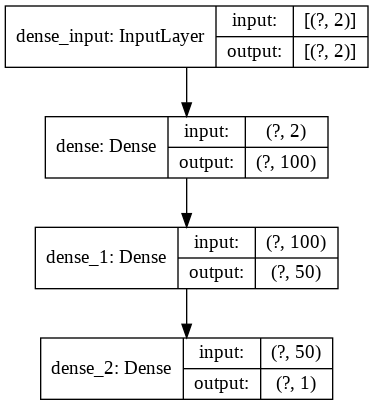

In [8]:
model = make_model()
model.summary()
tf.keras.utils.plot_model(model, show_shapes = True)

In [9]:
#now do training
#note to self: add validation data or cv

model.fit(X_train, y_train, batch_size = 100, epochs = 300)

Epoch 1/300
25/25 [==============================] - 0s 1ms/step - loss: 8256.5928
Epoch 2/300
25/25 [==============================] - 0s 1ms/step - loss: 7178.3496
Epoch 3/300
25/25 [==============================] - 0s 1ms/step - loss: 5900.7539
Epoch 4/300
25/25 [==============================] - 0s 1ms/step - loss: 4809.7905
Epoch 5/300
25/25 [==============================] - 0s 1ms/step - loss: 4395.8086
Epoch 6/300
25/25 [==============================] - 0s 1ms/step - loss: 4343.9761
Epoch 7/300
25/25 [==============================] - 0s 1ms/step - loss: 4344.9834
Epoch 8/300
25/25 [==============================] - 0s 1ms/step - loss: 4345.2939
Epoch 9/300
25/25 [==============================] - 0s 1ms/step - loss: 4341.2280
Epoch 10/300
25/25 [==============================] - 0s 1ms/step - loss: 4341.3418
Epoch 11/300
25/25 [==============================] - 0s 1ms/step - loss: 4341.4155
Epoch 12/300
25/25 [==============================] - 0s 1ms/step - loss: 4340.2422
E

In [10]:
#check the root mean squared error of the predictions
#basically, lower is better


np.sqrt(model.evaluate(X_test,y_test))

20/20 [==============================] - 0s 930us/step - loss: 3407.9314


58.377490494919144

In [14]:
#compare predictions to actual values

predictions = model.predict(X_test)
ser = pd.Series(predictions.ravel())
ser.index = X_test.index
ser.name = 'Predictions'

compare_df = X_test.join(y_test).join(ser)
compare_df['difference'] = compare_df['11/15/20'] - compare_df['Predictions']
compare_df

,Diabetes_Percentage,Heart_Hospitalizations,11/15/20,Predictions,difference
2907,8.4,0.0664,42.918163,57.279160,-14.360997
3760,12.3,0.0628,97.764611,72.670044,25.094567
4382,12.4,0.0660,353.968074,73.203606,280.764468
2881,10.4,0.0747,62.029081,65.600044,-3.570964
5571,12.8,0.0686,61.268253,74.907448,-13.639195
...,...,...,...,...,...
4557,8.3,0.0363,62.305296,55.610508,6.694788
5459,10.1,0.0774,116.497894,64.518387,51.979507
4220,6.0,0.0364,25.484200,46.448475,-20.964275
4861,10.3,0.0726,48.518325,65.112907,-16.594582


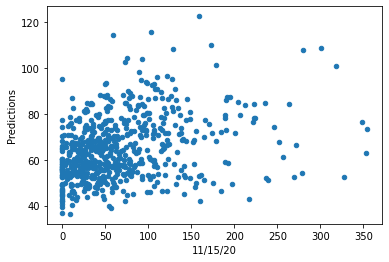

In [16]:
#plot actual value vs predictions
#ideally, this is a perfect straight line y=x

compare_df.plot(x = '11/15/20', y='Predictions', kind = 'scatter')

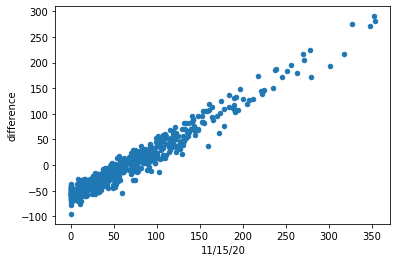

In [15]:
#plot actual value vs difference between the two
#ideally, this should be a flat line at 0, but clearly it's not

compare_df.plot(x='11/15/20', y='difference', kind='scatter')

From a quick glance, the model isn't looking too good right now

